<font size="18">Image Augmentation APP</font>

This application demonstrates a simple rocAL pipeline with different interpolation type on resize augmentation supported by rocAL.<br>
Illustrated below how to create a pipeline with resize augmentations with different interpolation type , set outputs , build , run the pipeline and enumerate over the results.

<font size="12"> Common Code </font>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from amd.rocal.plugin.pytorch import ROCALClassificationIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
from parse_config import parse_args
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

import cv2
def draw_patches(img, idx, device):
    if device == "cpu":
        image = img.detach().numpy()
    else:
        image = img.cpu().numpy()
    image = (image).astype('uint8')
    return image

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font size= "12" >Configuring rocAL pipeline </font>

Configure the pipeline paramters as required by the user.

In [2]:
data_path = "/media/sample_test/coco/test_image/"
rocal_cpu = True
device = "cpu" 
batch_size =  1
num_threads = 1
random_seed = 1
local_rank =  0
world_size =  1
display = True 

In [3]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=local_rank, seed=random_seed, rocal_cpu=rocal_cpu, tensor_layout=types.NHWC ,tensor_dtype=types.FLOAT)


Pipeline has been created succesfully
OK: loaded 81 kernels from libvx_rpp.so


<font size="12"> Image augmentation pipeline </font>

Here we use the file reader followed by the turbo jpeg decoder. In this pipeline we add cascaded augmentation on the decoded image.<br>We enable the output for differnet augmentaion using set_output

In [4]:
resize_w = 100
resize_h = 100
with pipe:
        jpegs, _ = fn.readers.file(file_root=data_path, shard_id=local_rank, num_shards=world_size, random_shuffle=False)
        images = fn.decoders.image(jpegs, file_root=data_path, device=1, output_type=types.RGB, shard_id=0, num_shards=1, random_shuffle=False)
        output_linear = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.LINEAR_INTERPOLATION )
        output_nearest_neighbor = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.NEAREST_NEIGHBOR_INTERPOLATION )
        output_cubic = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.CUBIC_INTERPOLATION )
        output_lanczos = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.LANCZOS_INTERPOLATION )
        output_gaussian = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.GAUSSIAN_INTERPOLATION )
        output_triangular = fn.resize(images, device=0, resize_x=resize_w, resize_y=resize_h,interpolation_type=types.TRIANGULAR_INTERPOLATION )
        
        pipe.set_outputs(output_linear,output_nearest_neighbor,output_cubic,output_lanczos,output_gaussian,output_triangular)


In [5]:
pipe.build()
# Dataloader
data_loader = ROCALClassificationIterator(pipe)

<font size ="12">Visualizing  outputs</font>

We have displayed  the output of augmented image using imshow()

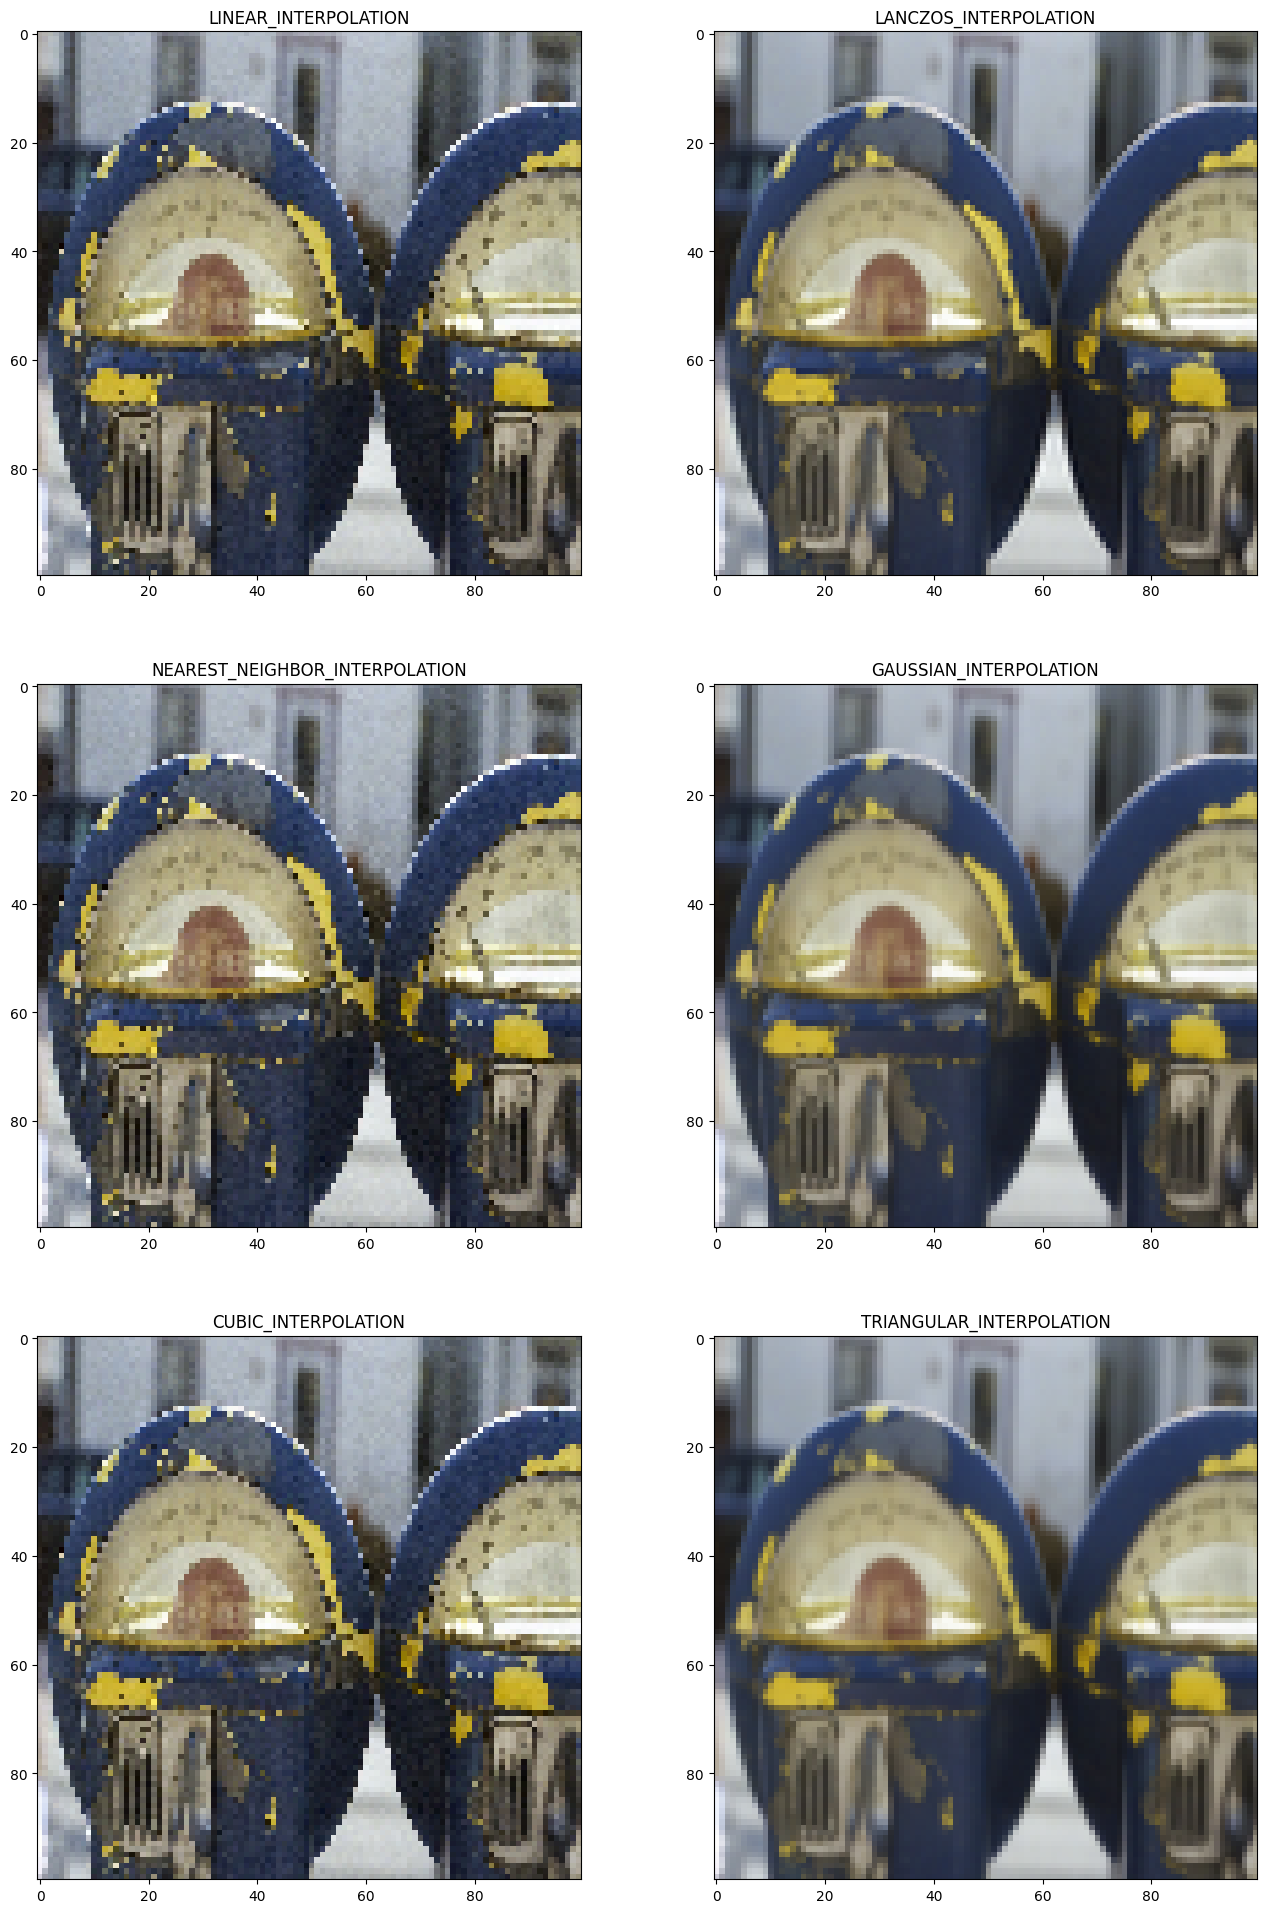

In [6]:
cnt = 0
aug_list=["LINEAR_INTERPOLATION","NEAREST_NEIGHBOR_INTERPOLATION","CUBIC_INTERPOLATION", "LANCZOS_INTERPOLATION","GAUSSIAN_INTERPOLATION", "TRIANGULAR_INTERPOLATION"] 
row=0
col=0
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,24))
for i, it in enumerate(data_loader,0):
    for img in it[0]: 
        if(cnt<len(aug_list)):
            axes[row,col].set_title(aug_list[cnt])
        cnt = cnt+1
        axes[row,col].imshow(draw_patches(img, cnt, device))
        row=row+1
        if(row==3):
            row=0
            if(col!=2):
                col =col+1
data_loader.reset()